# Facial Expressions Detection

## Video Classification and Object Detection with PyTorch and Open CV

## Background

Lymph node metastases occur in most cancer types (e.g. breast, prostate, colon). Lymph nodes are small glands that filter lymph, the fluid that circulates through the lymphatic system. The lymph nodes in the underarms are the first place breast cancer is likely to spread. Metastatic involvement of lymph nodes is one of the most important prognostic variables in breast cancer. The diagnostic procedure for pathologists is, however, tedious and time-consuming and prone to misinterpretation. 

Automated detection of lymph node metastasis has a great potential to help the pathologist. Within the past few years, the field has been moving towards a fully automated analysis of whole-slide images to detect cancer, to predict prognosis or identify metastases. 

This is a Kaggle competition, in which one must create an algorithm that identifies metastatic cancer in small image patches taken from larger digital pathology scans of lymph nodes. The data for this competition is a modified version of the PatchCamelyon [(PCam)](https://github.com/basveeling/pcam) benchmark dataset.

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

    [PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

## Dataset

The dataset used was from the Kaggle facial expression recognition competition, which can be found [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). It contains over 35,000 images, with each one classied with one of the following 7 emotions: (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [47]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

import torchvision

import cv2

## Importing the Data

In [2]:
path = Path('')

In [3]:
# listing the folder directory
path.ls()

[WindowsPath('.git'),
 WindowsPath('.ipynb_checkpoints'),
 WindowsPath('Facial Expression Detection - Keras.ipynb'),
 WindowsPath('Facial Expression Detection - Pytorch.ipynb'),
 WindowsPath('fer2013.csv'),
 WindowsPath('fer2013.tar.gz'),
 WindowsPath('haarcascade_frontalface_alt.xml'),
 WindowsPath('trained-model.h5')]

We can use the pandas library to create a dataframe so we can see how our dataset is labeled.

In [4]:
dataframe = pd.read_csv(path/'fer2013.csv')
dataframe.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


- The first column is emotion.  Each emotion is assigned a numerical value. 
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
- The second column contains the pixels for each image.  Each image is of size 48x48 for 2,304 numerical values or pixels. Each numerical value ranges from 0 to 255.
- The third column contains the usage, which tells us if each image is going to be used for for training or testing. We will ignore this column and create our own training and validation set.

In [5]:
# Counting the number of images
print("The dataset has", dataframe.pixels.count(), 'images.')

The dataset has 35887 images.


In [6]:
# Number of pixels for the first image in the set
pixels_list= dataframe.pixels[0].split(' ')
len(pixels_list)

2304

In [7]:
# Variables inside the "Usage" column.
dataframe.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

## Visualizing the Data

It's pretty easy to visualize an image using the matplotlib library.  Then, we first take the image from above and turn it into an array.  We convert its pixel values into floats.  And finally, we plot the image using plt.imshow().

In [8]:
pixels_list = np.array(pixels_list)

In [9]:
pixels_list = pixels_list.astype('float32')

Emotion: 0


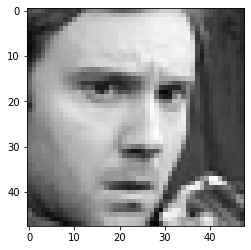

In [10]:
print("Emotion:", dataframe.emotion[0])
plt.imshow(pixels_list.reshape((48,48)), cmap="gray");

In the picture above the emotion is 0 or Angry.

### Now we'll plot the images and label them as positive or negative

## Creating a Databunch

A databunch is used to prepare the data so it can be trained using the fastai [Learner class](https://docs.fast.ai/basic_train.html#Learner).

### Data Augmentation

Data augmentation is technique used to increase the amount of training data by using information only in our training dataset. It can be used as a way we to reduce overfitting on models. Instead of feeding the model with the same pictures every time, we do small random transformations that don't change what's inside the image (for the human eye) but change its pixel values. Models trained with data augmentation will then generalize better.

We will flip the images horizontally, vertically, add a little bit of brightness, zoom and lighting. For more information on doing data augmentation with the fastai library, refer to [this link](https://docs.fast.ai/vision.transform.html#Data-augmentation).

In [11]:
tfms=get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=0.15,
               max_lighting=0.5, max_warp=0., p_affine=0.5, p_lighting=0.50)

### Preparing The Data

In [12]:
dataframe.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
images = [i.split(' ') for i in dataframe.pixels]

In [ ]:
# yes = np.array(secondarray)
# yes.shape

In [15]:
images_array = np.array(images)

In [16]:
images_array.shape

(35887, 2304)

Now the images_array is a numpy array of 35,887 images by 2,304 (48x48) pixels each.

We do a similar procedure for the labels.

### Standardizing The Data
We want the pixels to be between the numbers of 0 and 1.  Standardization helps the model train faster.

In [141]:
#images_array[0]=images_array[0]*255

In [17]:
# The .values method converts a dataframe column into a numpy array
labels = dataframe.emotion.values

In [18]:
labels.shape

(35887,)

In [19]:
labels.dtype, images_array.dtype

(dtype('int64'), dtype('<U3'))

In [20]:
# Converting our arrays into floats
images_array = images_array.astype('float32')
labels = labels.astype('float32')

### Turning the Data into PyTorch Tensors

In order to feed the data into our model. They have to be converted into tensors first. The data will be called xvalues and yvalues for the images and labels, respectively.

In [21]:
xvalues, yvalues = map(torch.tensor, (images_array, labels))

Now we set the validation test and the test set to be 10% each of the total set. Then we set the training set to be 80% of the data.

In [22]:
len(xvalues), len(xvalues)*.9

(35887, 32298.3)

In [23]:
xtest = xvalues[32298:-1]
ytest = yvalues[32298:-1]
len(xtest)

3588

In [24]:
32298-3588

28710

In [25]:
xvalid = xvalues[28710:32298]
yvalid = yvalues[28710:32298]
len(xvalid)

3588

In [26]:
xtrain = xvalues[0:28710]
ytrain = yvalues[0:28710]
len(xtrain)

28710

In [27]:
xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape

(torch.Size([28710, 2304]),
 torch.Size([28710]),
 torch.Size([3588, 2304]),
 torch.Size([3588]))

Now the Datasets

In [28]:
# We create 3 Pytorch datasets
train_ds = TensorDataset(xtrain, ytrain)
valid_ds = TensorDataset(xvalid, yvalid)
test_ds = TensorDataset(xtest, ytest)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train__transforms = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
valid_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
train_ds = train__transforms(train_ds)
valid_ds = valid_transforms(valid_ds)
test_ds = valid_transforms(train_ds)

In [ ]:
plt.imshow(train_ds[0], cmap="gray");

And the PyTorch Dataloaders

In [29]:
bs = 64 # batch size

In [30]:
train_dl = DataLoader(train_ds, batch_size=bs)
valid_dl = DataLoader(valid_ds, batch_size=bs)
test_dl = DataLoader(test_ds, batch_size=bs)

In [ ]:
dataloaders_dict = {'train': train_dl, 'val': valid_dl}

### The Databunch

In [35]:
data = ImageDataBunch(train_dl=train_dl, valid_dl=valid_dl, test_dl=test_dl);

Now that the databunch is created, there are many functions that can be called from the object "data".

In [36]:
x, y = next(iter(data.train_dl)) # Here we are getting the x and the y from the dataloader with batch size = 64
# We are grabbing the next item of the iterator
x.shape,y.shape

(torch.Size([64, 2304]), torch.Size([64]))

In [37]:
# Length of train, validation, and test sets
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(28710, 3588, 3588)

## Training The Model

### Model architecture

To train this model we will use a technique called transfer learning where we will use a model trained on a very large dataset and then adapt it to our own dataset. Here we will use a pre-trained convolutional network model with ResNet 50 architecture. It comes pretrained from ImageNet so its weights have already been computed for us. It has already learned to recognize many features on all of its images, so we can benefit from this knowledge, instead of starting with a randomly initiliazed model.

In [39]:
arch = models.resnet18

In [14]:
#arch()

The final layers (avgpool and fc) are replaced with new layers made specifically for our model.  Notice how the final layer fc here has out_features=1,000, which corresponds to 1,000 classes in Imagenet.  Our model will only have 7 classes. All the layers before the last 2 remain the same.  Their training information stays the same.

### Metrics

In [40]:
metrics = [accuracy]

### Training the model

In [41]:
wd=0.1 # weight decay

In [10]:
import torch
import torchvision
from torchvision import datasets, models, transforms

In [12]:
print("PyTorch Version: ", torch.__version__)

PyTorch Version:  1.3.0


In [ ]:
model_name = "resnet18"

num_classes = 7

batch_size = 64

num_epochs = 30

# When False, we finetune the whole model, when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Everything below happens during each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        # Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # history is track only if we're training
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)
                
                # Backward pass + optimize during training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss/ len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc: 
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
            val_acc_history.append(epoch_acc)
    
    print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# Set params.requires_grad = False if we are feature extracting
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Preparing our model for resnet
model.fc = nn.Linear(512, num_classes)

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
   # input_size = 224
    
    return model_ft, input_size

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Send the model to the GPU
model_ft = model_ft.to(device)

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
            
else:
    for name, param in odel_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

In [ ]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
# Setup the loss function
criterion = nn.CrossEntropyoss()

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [15]:
#learn = cnn_learner(data, base_arch=arch, metrics=metrics, wd=wd)

In [16]:
#learn.model

Notice the last layers in this model starting from AdaptiveConcatPool2d. They have replaced the last 2 layers in the ResNet 50 network.  You can also see that the last layer has out_features=2, which corresponds to the 2 classes we have.

In [46]:
learn.lr_find() 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


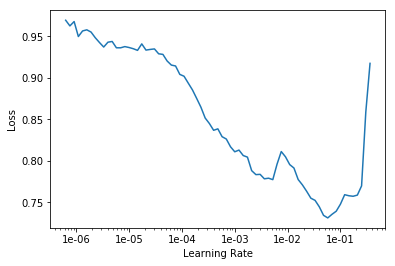

In [47]:
learn.recorder.plot() # We plot the learning rate vs loss to select the best value to train the model

In [49]:
lr=1e-2 # We want to select a learning rate that's on the downward slope, but not to close to the end of the slope.

In [50]:
# Now we train for 5 epochs
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.214574,0.169072,0.936006,0.982477
2,0.177719,0.139814,0.950459,0.985624
3,0.157940,0.130150,0.954004,0.987729
4,0.123590,0.104669,0.964458,0.991711
5,0.132966,0.095601,0.968367,0.992460


In [51]:
learn.save('hcd-stage-1') # We save the model up to this point

### Fine Tuning

The model has achieved an accuracy of 96.8%, but this can be improved.  Previously, by default, the model was trained with its initial layers frozen. Now we will unfreeze all the layers in the model and train again.

In [19]:
learn.load('hcd-stage-1');

In [52]:
learn.unfreeze()

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


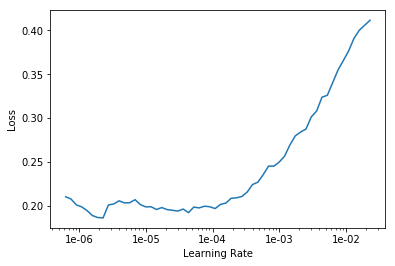

In [22]:
learn.recorder.plot()

In [54]:
doc(fit_one_cycle)

In [55]:
learn.fit_one_cycle(3, slice(1e-5,lr/10))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.147020,0.126718,0.955913,0.988199
2,0.119397,0.095718,0.967730,0.992917
3,0.087570,0.080145,0.972912,0.994723


In [56]:
learn.save('hcd-stage-2')

The accuracy a little to 97.2%. We will try it once more.

In [57]:
learn.load('hcd-stage-2');

In [58]:
learn.unfreeze()

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


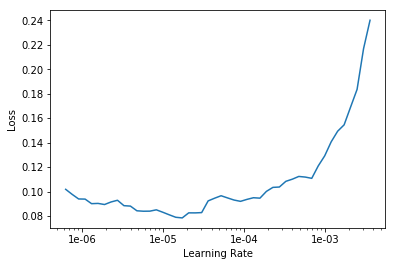

In [60]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(2, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.090719,0.078748,0.973366,0.994900
2,0.093722,0.075200,0.975639,0.995333


In [62]:
learn.save('hcd-stage-3')

We'll run it once again to see if we can improve the accuracy and AUC score.

In [18]:
learn.load('hcd-stage-3');

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


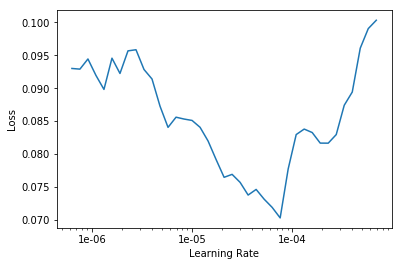

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.082385,0.075018,0.976366,0.995310
2,0.084545,0.074588,0.975002,0.995529


In [23]:
learn.save('hcd-stage-4')

It looks like the accuracy didn't imporve much so we'll stop here

In [ ]:
learn.load('hcd-stage-4');

# Model Classification Interpretation

We can see the confusion matrix and also plot the algorithms worse predictions of the validation set


In [24]:
inter = ClassificationInterpretation.from_learner(learn)

In [29]:
doc(inter.plot_top_losses)

## Plotting Top Losses

These are the images in the validation set that resulted with the highest loss after training. Above each image you'll see the predicted class (1 or 0), the actual class, the calculated loss, and the probability of the predicted class.

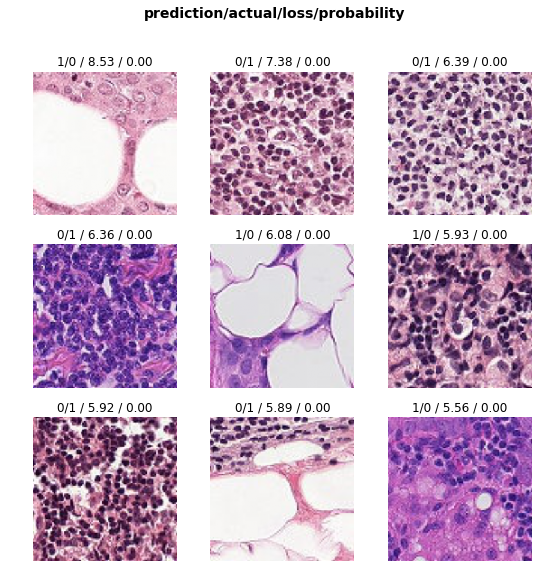

In [27]:
inter.plot_top_losses(9, figsize=(9,9))

## Confusion Matrix

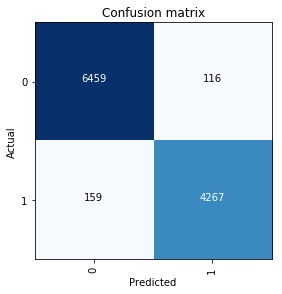

In [30]:
inter.plot_confusion_matrix()

# Predictions

In [32]:
# Test Time Augmentation
preds, test_labels = learn.TTA(ds_type=DatasetType.Test)

In [33]:
len(preds)

57458

In [35]:
# Creating a dataframe for the predictions in order to submit them
testdf = data.test_ds.to_df()
testdf.columns = ['id','label']
testdf['label'] = preds[:,1]
testdf['id'] = testdf['id'].apply(lambda fp: Path(fp).stem)
testdf.head()

,id,label
0,14b7966df72b115f7adfcf3eecd2ba1482691ed2,0.157784
1,221fd906e8eb4bce8fa6ac8f778dc53a6773a15a,0.069415
2,12ea9a4bdcd424dd5d6cd7b859c9583bef15b7e0,0.602393
3,943865c868a904087eac1c896ea166703184d95d,0.855023
4,154ab1ff17a7452b26adf570b0f728e1d38a785a,0.654372


The predictions are the probability that a class is either 0 or 1.

In [36]:
# Saving the predictions to a file
testdf.to_csv('submission36 - Kaggle - size=224.csv ', index=False)